## Random spawn objects and Setup about RealWorld workspace

### Spawn other objects with `UR5e`

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mujoco_parser import MuJoCoParserClass,get_env_obj_names,set_env_obj,set_env_objs,get_env_obj_poses, set_env_joint_configuration
from pid import PID_ControllerClass
np.set_printoptions(precision=2)
plt.rc('xtick',labelsize=6); plt.rc('ytick',labelsize=6)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
print ("Ready.")

Done.
Ready.


### Parse `UR5e` with objects

In [2]:
# env = MuJoCoParserClass(name='UR5e',xml_path='../asset/ur5e/test_calibration.xml')
# env = MuJoCoParserClass(name='UR5e',xml_path='../asset/ur5e/test_2.xml')
env = MuJoCoParserClass(name='UR5e',xml_path='../asset/ur5e/UR5_rg2_gripper.xml')

print ("[%s] parsed."%(env.name))

[UR5e] parsed.


In [3]:
# Check available objects whose names start with 'obj_'

obj_names = get_env_obj_names(env,prefix='obj_') # see objects
for obj_idx,obj_name in enumerate(obj_names):
    print ("[%d/%d] obj_name:[%s]"%(obj_idx,len(obj_names),obj_name))


[0/7] obj_name:[obj_cylinder_1]
[1/7] obj_name:[obj_cylinder_2]
[2/7] obj_name:[obj_cylinder_3]
[3/7] obj_name:[obj_cylinder_1_thick]
[4/7] obj_name:[obj_cylinder_2_thick]
[5/7] obj_name:[obj_cylinder_3_thick]
[6/7] obj_name:[obj_box_1]


### Get camera informations

In [4]:
cam_infos = env.set_cam_infos(cam_distance  = 0.0,
                    cam_azimuth   = 0.0,
                    cam_elevation = -90.0,
                    cam_lookat    = [1.4,0.0,2.0])
cam_infos

{'cam_distance': 0.0,
 'cam_azimuth': 0.0,
 'cam_elevation': -90.0,
 'cam_lookat': array([1.4, 0. , 2. ])}

### Render a scene

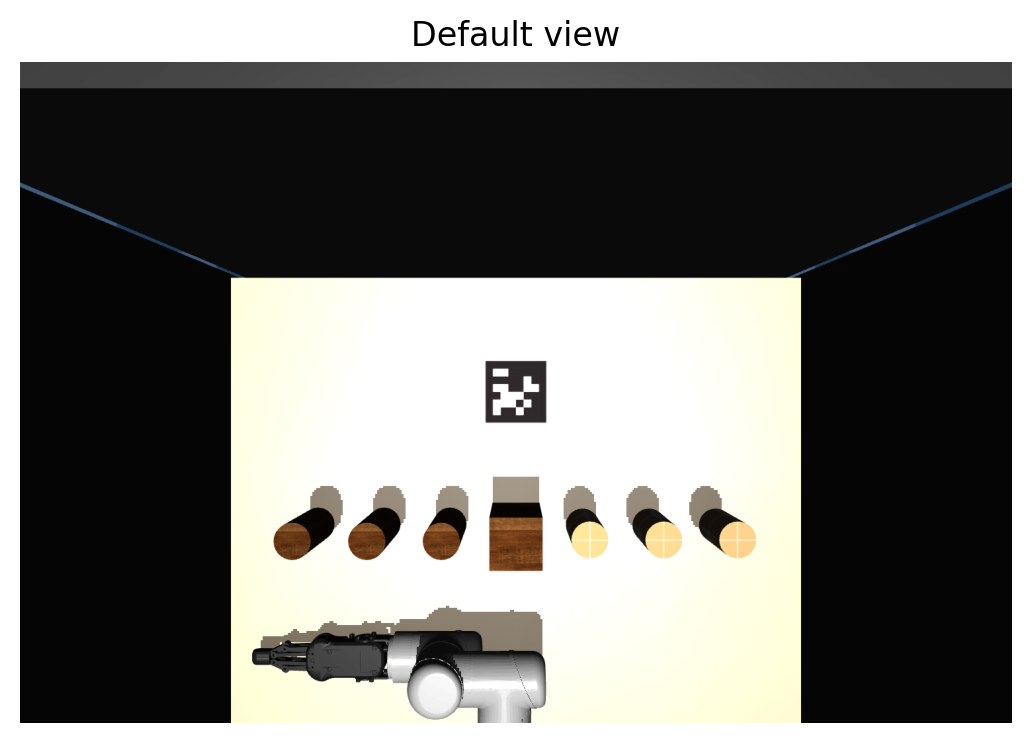

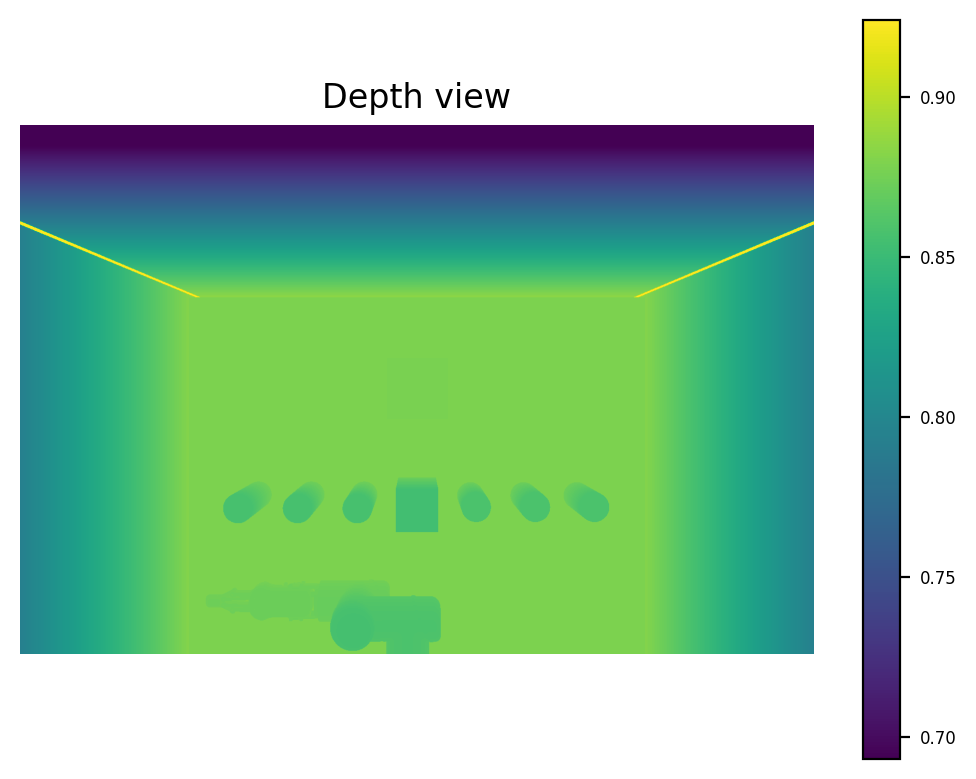

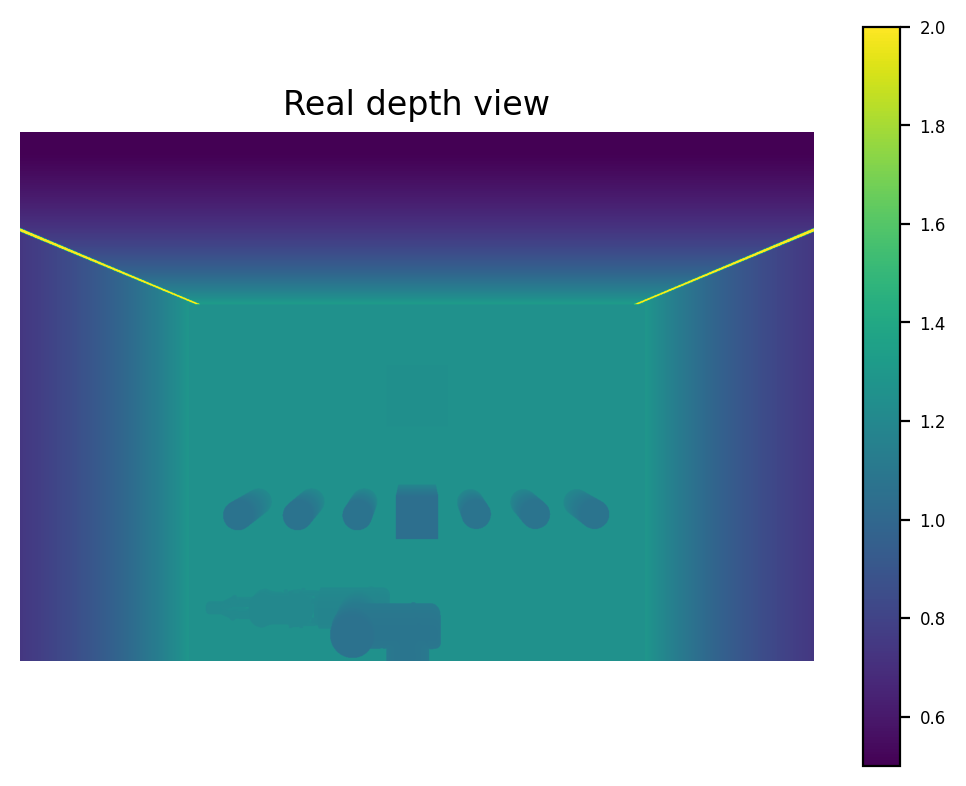

In [5]:
import math

width = 1500
height = 1000
ur_joint_idx = np.array([0, 1, 2, 3, 4, 5, 6], dtype=np.int32)

# env.sim.data.qpos[:8] = [-math.pi/2, -3*math.pi/4, 3*math.pi/4, math.pi/2, math.pi/4, -math.pi/2, 0, 0] 
# torque = [-math.pi/2, -6*math.pi/8, 2*math.pi/3, math.pi/2, math.pi/4, 0, False] 
# env.step(ctrl=torque, ctrl_idxs=ur_joint_idx)

for _ in range(2):
    img = env.render_scene(mode='rgb_array', cam_infos=cam_infos, width=width, height=height, depth_toggle=False, camera_name="track")
    img_depth = env.render_scene(mode='rgb_array', cam_infos=cam_infos, width=width, height=height, depth_toggle=True, camera_name="track")
    img_real = env.depth_2_meters(img_depth)

plt.imshow(img); plt.axis('off')
plt.title("Default view")
plt.show()

plt.imshow(img_depth); plt.axis('off')
plt.title("Depth view")
plt.colorbar()
plt.show()

plt.imshow(img_real); plt.axis('off')
plt.title("Real depth view")
plt.colorbar()
plt.show()

### Place objects in a row with different colors

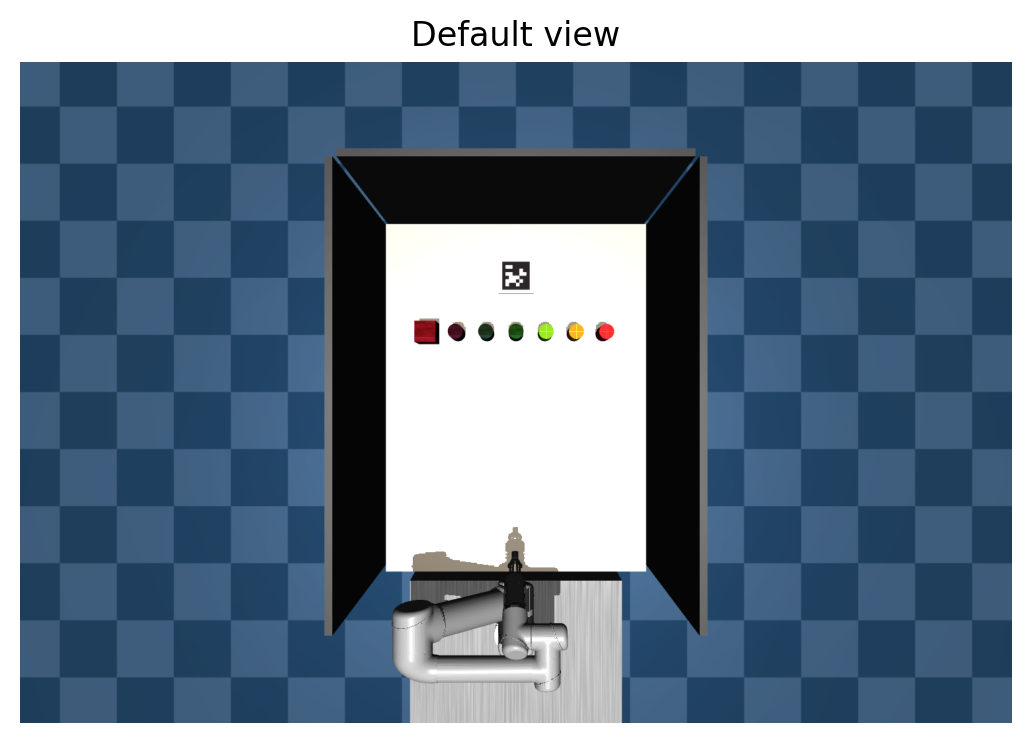

In [7]:
# Initialize position
colors = [plt.cm.gist_rainbow(x) for x in np.linspace(0,1,len(obj_names))]
for obj_idx,obj_name in enumerate(obj_names):
    obj_pos   = [1.2,-0.3+0.1*obj_idx,0.8]
    obj_quat  = [0,0,0,1]
    obj_color = colors[obj_idx]
    set_env_obj(env=env,obj_name=obj_name,obj_pos=obj_pos,obj_quat=obj_quat,obj_color=obj_color)

# Set Joint Configurations
init_configurations = [-math.pi/2, -3*math.pi/4, 3*math.pi/4, math.pi/2, math.pi/4, -math.pi/2 ]
set_env_joint_configuration(env, init_configurations, prefix='ur_')

# update object locations
env.forward(INCREASE_TICK=False)

cam_infos = env.set_cam_infos(cam_distance  = 1.5,
                    cam_azimuth   = 0.0,
                    cam_elevation = -90.0,
                    cam_lookat    = [1.0,0.0,2.0])

for _ in range(2):
    img = env.render_scene(mode='rgb_array', cam_infos=cam_infos, width=width, height=height, depth_toggle=False, camera_name="track")
    img_depth = env.render_scene(mode='rgb_array', cam_infos=cam_infos, width=width, height=height, depth_toggle=True, camera_name="track")
    img_real = env.depth_2_meters(img_depth)

plt.imshow(img); plt.axis('off')
plt.title("Default view")
plt.show()

# plt.imshow(img_depth); plt.axis('off')
# plt.title("Depth view")
# plt.colorbar()
# plt.show()

# plt.imshow(img_real); plt.axis('off')
# plt.title("Real depth view")
# plt.colorbar()
# plt.show()

In [16]:
obj_ps,obj_Rs = get_env_obj_poses(env,obj_names)
obj_ps

array([[ 1.20e+00, -3.00e-01,  8.00e-01],
       [ 1.20e+00, -2.00e-01,  8.00e-01],
       [ 1.20e+00, -1.00e-01,  8.00e-01],
       [ 1.20e+00,  5.55e-17,  8.00e-01],
       [ 1.20e+00,  1.00e-01,  8.00e-01],
       [ 1.20e+00,  2.00e-01,  8.00e-01],
       [ 1.20e+00,  3.00e-01,  8.00e-01]])

### Randomly spawn objects on a table

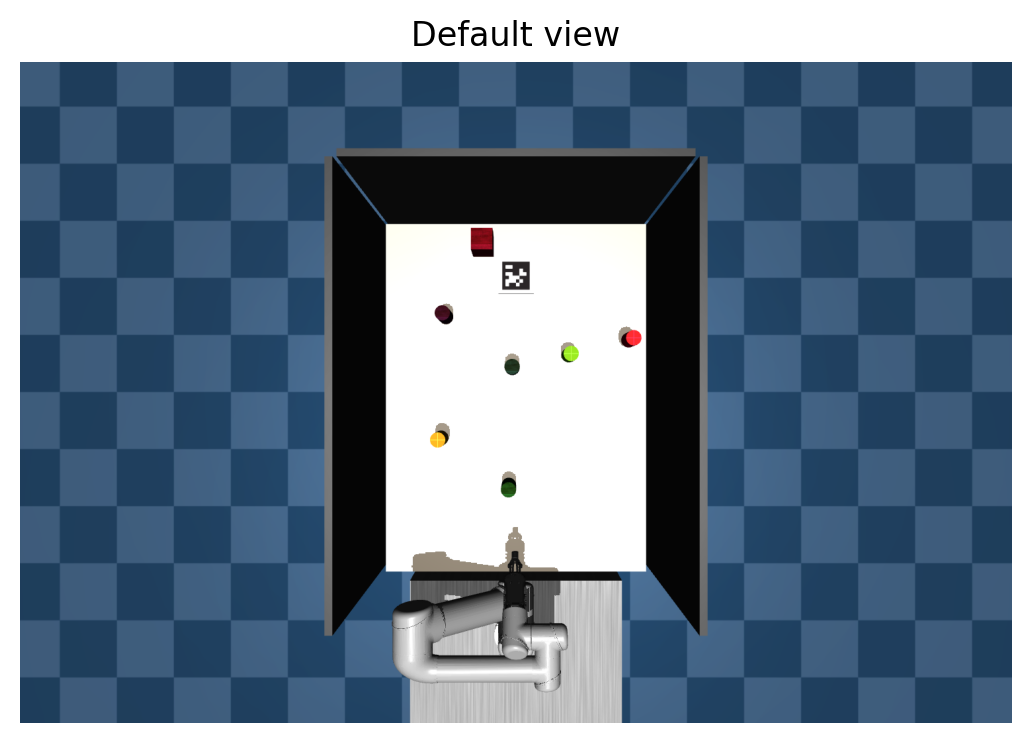

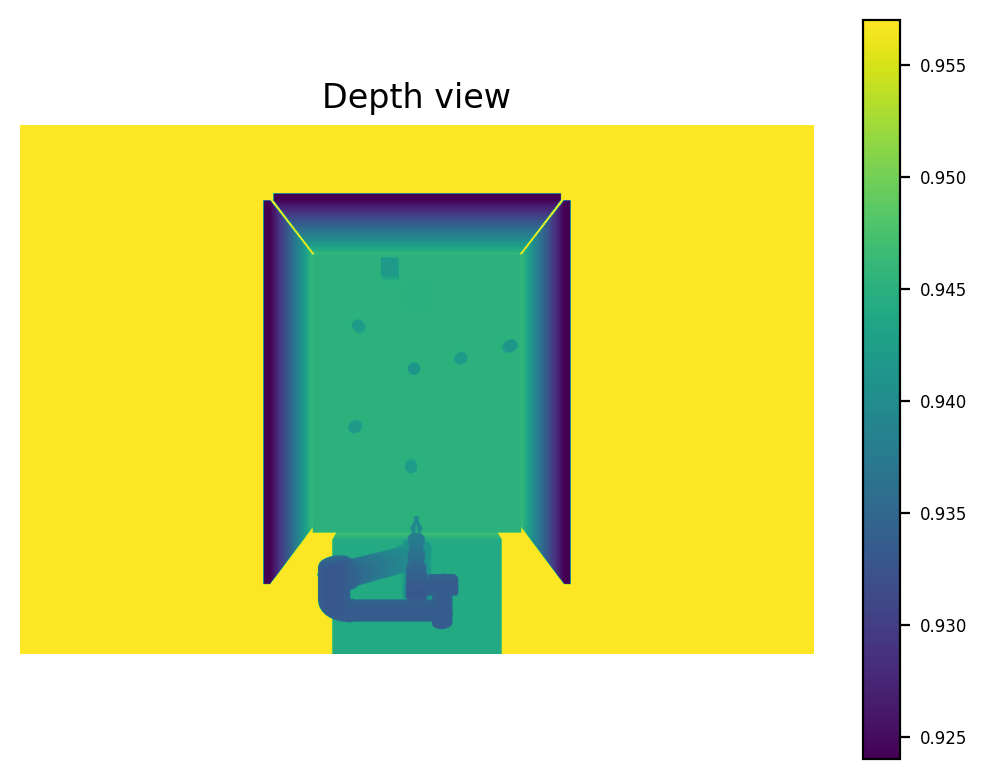

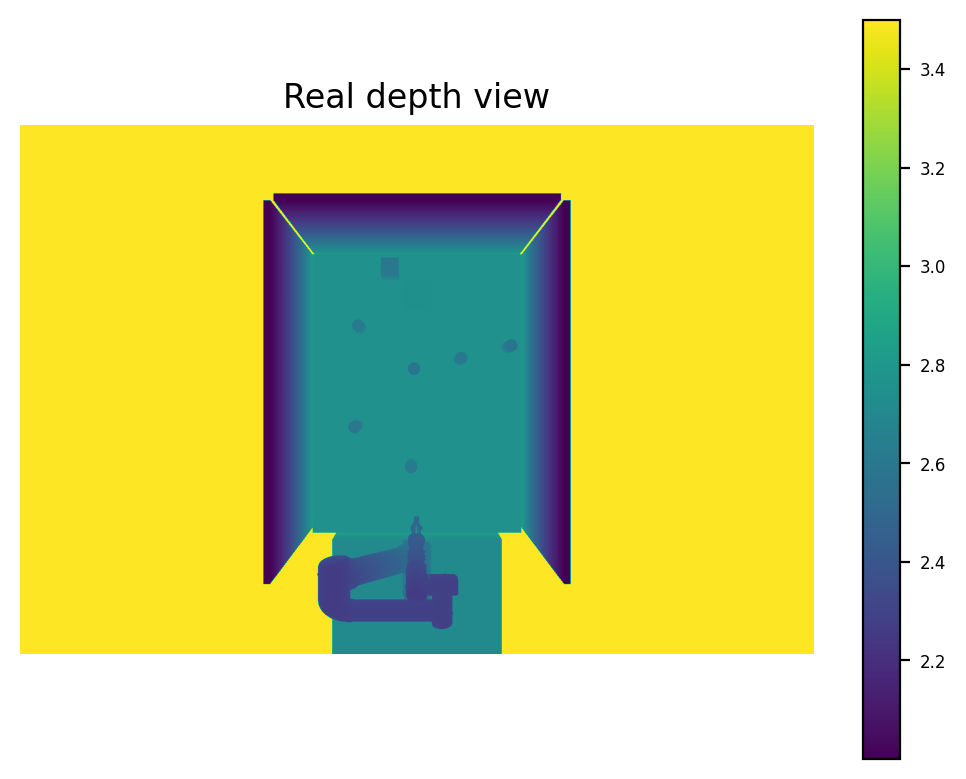

In [8]:
from scipy.spatial.distance import cdist

# Place objects in a row on the ground
obj_names = get_env_obj_names(env,prefix='obj_') # available objects

# Randomly place objects on the table
n_place  = 7
x_range  = [0.5,1.5]
y_range  = [-0.4,0.4]
z_range  = [0.8,0.86]
min_dist = 0.15

obj2place_idxs = np.random.permutation(len(obj_names))[:n_place].astype(int)
obj2place_names = [obj_names[o_idx] for o_idx in obj2place_idxs]
obj2place_poses = np.zeros((n_place,3))

for o_idx in range(n_place):
    while True:
        x = np.random.uniform(low=x_range[0],high=x_range[1])
        y = np.random.uniform(low=y_range[0],high=y_range[1])
        z = np.random.uniform(low=z_range[0],high=z_range[1])
        xyz = np.array([x,y,z])
        if o_idx >= 1:
            devc = cdist(xyz.reshape((-1,3)),obj2place_poses[:o_idx,:].reshape((-1,3)),'euclidean')
            if devc.min() > min_dist: break # minimum distance between objects
        else:
            break
    obj2place_poses[o_idx,:] = xyz
set_env_objs(env,obj_names=obj2place_names,obj_poses=obj2place_poses,obj_colors=None)

# Set Joint Configurations
init_configurations = [-math.pi/2, -3*math.pi/4, 3*math.pi/4, math.pi/2, math.pi/4, -math.pi/2 ]
set_env_joint_configuration(env, init_configurations, prefix='ur_')


# update object locations
env.forward(INCREASE_TICK=False)


for _ in range(2):
    img = env.render_scene(mode='rgb_array', cam_infos=cam_infos, width=width, height=height, depth_toggle=False, camera_name="track")
    img_depth = env.render_scene(mode='rgb_array', cam_infos=cam_infos, width=width, height=height, depth_toggle=True, camera_name="track")
    img_real = env.depth_2_meters(img_depth)

plt.imshow(img); plt.axis('off')
plt.title("Default view")
plt.show()

# plt.imshow(img_depth); plt.axis('off')
# plt.title("Depth view")
# plt.colorbar()
# plt.show()

# plt.imshow(img_real); plt.axis('off')
# plt.title("Real depth view")
# plt.colorbar()
# plt.show()